In [1]:
import sys
sys.path.append("/data/igor/deduplicate-text-datasets/scripts/near_duplicates")


%load_ext autoreload
%autoreload 2

In [203]:
from utils import Sequence, merge_results, print_near_duplicate_summary, bytes_to_ints
import os
import pickle
from tqdm.notebook import tqdm
from transformers import GPT2Tokenizer
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import traceback
from strsimpy.longest_common_subsequence import LongestCommonSubsequence
from strsimpy.levenshtein import Levenshtein
import copy
import numpy as np
from concurrent.futures import (ProcessPoolExecutor,
                                as_completed)

In [137]:
DS_PATH = "/home/igor/rds/ephemeral/datasets/tokenized/slimpajama_0_of_20.train"
DS_SIZE_PATH = "/home/igor/rds/ephemeral/datasets/tokenized/slimpajama_0_of_20.train.size"

In [4]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

In [5]:
with open(DS_SIZE_PATH, "rb") as f:
    ds_size_raw = f.read()
    ds_size = bytes_to_ints(ds_size_raw, 8)

print("loaded sizes")

with open(DS_PATH, "rb") as f:
    ds = f.read()

print("loaded full dataset")

loaded sizes
loaded full dataset


In [214]:
RESULTS_DIR = "/home/igor/rds/home/mosaic/scan"

total = 0
# results = None
extra_files = ["res_21205264_21205632.pkl", "res_29439632_29500880.pkl"]

# for filename in tqdm(sorted(os.listdir(RESULTS_DIR))):
for filename in tqdm(extra_files):
    try:
        with open(os.path.join(RESULTS_DIR, filename), "rb") as f:
            new_results = pickle.load(f)    
        if results is None:
            results = new_results
        else:
            results = merge_results(results, new_results)
        total += 1
    except:
        traceback.print_exc()


len(results)

  0%|          | 0/2 [00:00<?, ?it/s]

500

In [169]:
# len(results), total

In [ ]:
# with open("/data/igor/deduplicate-text-datasets/merged_results_80k.pkl", "wb") as f:
#     pickle.dump(results, f)

In [223]:
with open("/data/igor/deduplicate-text-datasets/merged_results_80k.pkl", "rb") as f:
    results = pickle.load(f)

In [224]:
results_filtered = []
for r in results:
    # if r.bucket < 100:
    #     continue

    if r.bucket > 100:
        results_filtered.append(r)
        continue
    
    exact = len([x for x in r.near_duplicates["hamming"] if x[1] == 0])
    if r.bucket != -1 and exact > r.bucket // 20:
        continue
    
    results_filtered.append(r)

results = results_filtered

In [225]:
cum_counts = {}
for bucket in (-1, 10, 100, 1000, 10000):
    results_bucket = [x for x in results if x.bucket == bucket]
    cum_counts_tmp = defaultdict(list)
    for metric in ("hamming", "edit"):
        for dist in range(51):
            cnt = 0
            for r in results_bucket:
                near_dups_dist = [x for x in r.near_duplicates[metric] if x[1] <= dist]
                cnt += len(near_dups_dist)
            
            # correction for average
            cnt = (cnt / 100) * 20
            cum_counts_tmp[metric].append(cnt)
    
    cum_counts[bucket] = cum_counts_tmp

In [226]:
# results_bucket = [x for x in results_filtered if x.bucket == 100]
# res = []
# for r in results_bucket:
#     res.append(len([x for x in r.near_duplicates["hamming"] if x[1] == 0]))

# print(res)

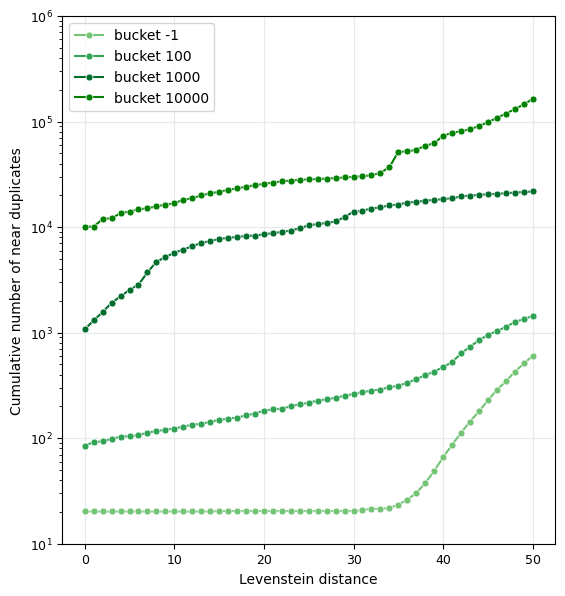

In [229]:
plt.figure(figsize=(6, 6))
# colors = ['teal', 'turquoise', 'cadetblue', 'aquamarine', 'lightseagreen']
colors = ['#74c476',
          '#31a354',
          '#006d2c',
          "green",]

# Plot for each bucket
for idx, bucket in enumerate((-1, 100, 1000, 10000)):
    # Plot with enhanced styling
    plt.plot(range(51), cum_counts[bucket]['edit'],
             #  linewidth=2.5,
             color=colors[idx],
             marker='o',
             markersize=5,
             markeredgecolor='white',
             markerfacecolor=colors[idx],
             markeredgewidth=0.5,
             label=f"bucket {bucket}")


plt.grid(True, linestyle='-', color='#E5E7EB', alpha=0.9, zorder=0)
plt.xlabel('Levenstein distance', fontsize=10)
plt.tick_params(labelsize=9)

plt.ylabel('Cumulative number of near duplicates', fontsize=10)
plt.legend(fontsize=10, loc="upper left")
# Adjust layout
plt.tight_layout()
plt.yscale('log')
plt.ylim(10, 1000000)
# plt.yticks(plt.yticks()[0].tolist() + [100])
# plt.show()
plt.savefig("/data/igor/canary/near_duplicate_experiment_neurips/figures/cum_near_duplicates_all_log_plus_random.pdf")

In [221]:
cum_counts[-1]['edit']

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

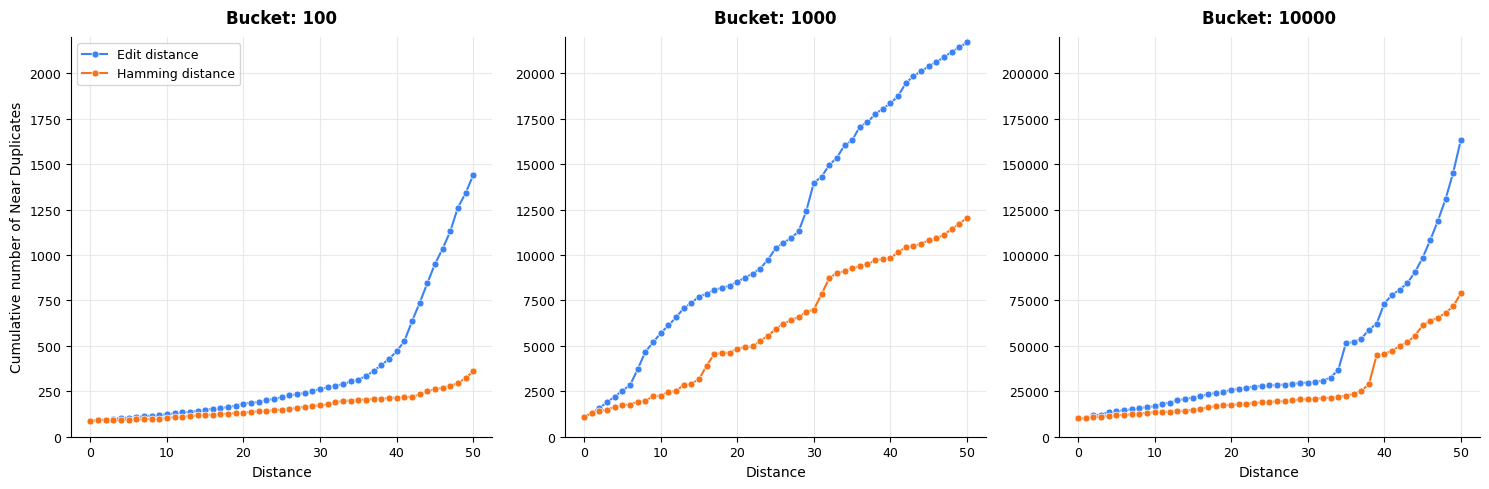

In [57]:
# Create the figure
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot for each bucket
for idx, bucket in enumerate((100, 1000, 10000)):
    # Plot with enhanced styling
    axes[idx].plot(range(51), cum_counts[bucket]['edit'], 
            #  linewidth=2.5,
             color='#3B82F6',
             marker='o',
             markersize=5,
             markeredgecolor='white',
             markerfacecolor='#3B82F6',
             markeredgewidth=0.5,
             label="Edit distance")

    axes[idx].plot(range(51), cum_counts[bucket]['hamming'],
            #  linewidth=2.5, 
             color='#F97316',
             marker='o',
             markersize=5,
             markeredgecolor='white',
             markerfacecolor='#F97316',
             markeredgewidth=0.5,
             label="Hamming distance")

    # Customize each subplot
    axes[idx].grid(True, linestyle='-', color='#E5E7EB', alpha=0.9, zorder=0)
    axes[idx].set_title(f'Bucket: {bucket}', fontsize=12, pad=10, fontweight='bold')
    axes[idx].set_xlabel('Distance', fontsize=10)
    axes[idx].spines['top'].set_visible(False)
    axes[idx].spines['right'].set_visible(False)
    axes[idx].tick_params(labelsize=9)

    if bucket > 0:
        axes[idx].set_ylim(0, 22*bucket)

# Remove the empty subplot
# axes[5].remove()

axes[0].set_ylabel('Cumulative number of Near Duplicates', fontsize=10)
axes[0].legend(fontsize=9, loc="upper left")
# Adjust layout
plt.tight_layout()
plt.show()

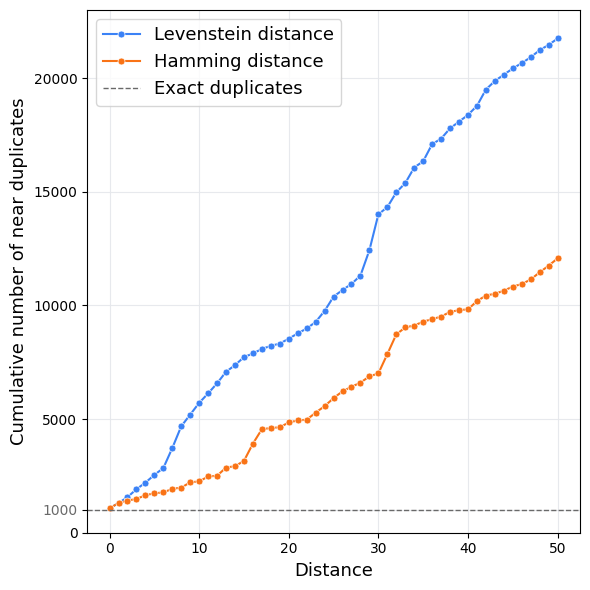

In [275]:
plt.figure(figsize=(6, 6))
bucket = 1000

plt.plot(range(51), cum_counts[bucket]['edit'], 
    #  linewidth=2.5,
     color='#3B82F6',
     marker='o',
     markersize=5,
     markeredgecolor='white',
     markerfacecolor='#3B82F6',
     markeredgewidth=0.5,
     label="Levenstein distance")

plt.plot(range(51), cum_counts[bucket]['hamming'],
        #  linewidth=2.5, 
         color='#F97316',
         marker='o',
         markersize=5,
         markeredgecolor='white',
         markerfacecolor='#F97316',
         markeredgewidth=0.5,
         label="Hamming distance")

# plt.axhline(y=1000, color='dimgray', linestyle='--', alpha=0.9, linewidth=1.5, label="Exact duplicates")
plt.axhline(y=1000, xmin=0, xmax=1, color='dimgray', linestyle='--', linewidth=1, label="Exact duplicates")
# print(list(plt.yticks())[0])
plt.yticks(list(plt.yticks()[0]) + [1000])
plt.gca().get_yaxis().get_major_ticks()[-1].label1.set_color('dimgray')
# plt.gca().get_yaxis().get_major_ticks()[-1].label1.set_fontsize(12) 


plt.grid(True, linestyle='-', color='#E5E7EB', alpha=0.9, zorder=0)
plt.xlabel('Distance', fontsize=13)
plt.ylim(0, 23*bucket)
plt.ylabel('Cumulative number of near duplicates', fontsize=13)
plt.legend(fontsize=13, loc="upper left")
# Adjust layout
plt.tight_layout()
# plt.show()
plt.savefig("/data/igor/canary/near_duplicate_experiment_neurips/figures/cum_near_duplicates_main.pdf")

## Dedup

In [141]:
def has_ngram_overlap(arr1, arr2, n):
    ngrams1 = set([tuple(arr1[i:i+n]) for i in range(len(arr1)-n+1)])
    ngrams2 = set([tuple(arr2[i:i+n]) for i in range(len(arr2)-n+1)])

    return len(ngrams1 & ngrams2) > 0

In [142]:
words = [len(tokenizer.decode(r.tokens).split(" ")) for r in results]
np.mean(words)

53.24475524475525

In [234]:
dedup_results = []
ngrams = range(10,110,10)
bucket = 1000

for r in tqdm(results):
    if r.bucket != bucket: 
        continue

    new_r = copy.deepcopy(r)
    new_r.near_duplicates_dedup = {}

    for ngram_size in ngrams:
        new_r.near_duplicates_dedup[ngram_size] = defaultdict(list)

    for metric in ("hamming", "edit"):
        for pos, dist in r.near_duplicates[metric]:
            nd_tokens = bytes_to_ints(ds[pos:pos+200],2)

            for ngram_size in ngrams:
                if not has_ngram_overlap(r.tokens, nd_tokens, n=ngram_size):
                    new_r.near_duplicates_dedup[ngram_size][metric].append((pos, dist))

    dedup_results.append(new_r)

  0%|          | 0/386 [00:00<?, ?it/s]

In [235]:
cum_counts_dedup = {}

metric="edit"

for ngram_size in ngrams:
    cum_counts_dedup[ngram_size] = defaultdict(list)
    for bucket in (100, 1000, 10000):
        results_bucket = [x for x in dedup_results if x.bucket == bucket]
        for dist in range(51):
            cnt = 0
            for r in results_bucket:
                cnt += len([x for x in r.near_duplicates_dedup[ngram_size][metric] if x[1] <= dist])
                
            # correction for average
            cnt = (cnt / 100) * 20

            cum_counts_dedup[ngram_size][bucket].append(cnt)

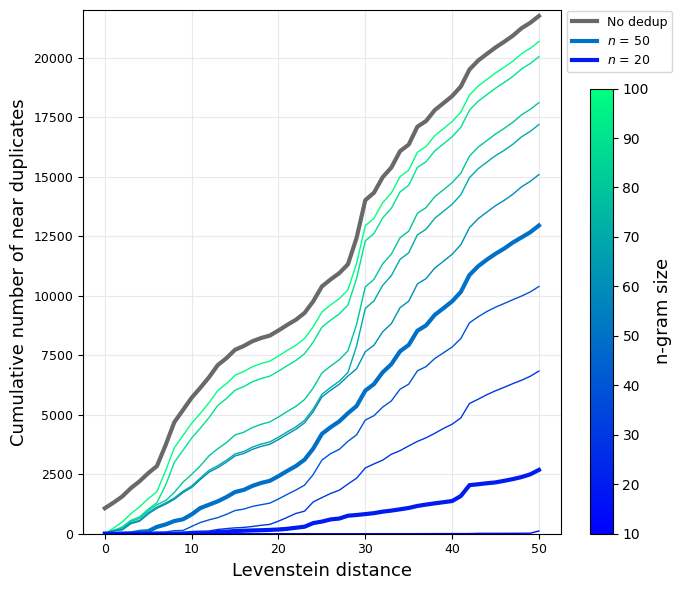

In [301]:
# Create the figure and axis
fig, ax = plt.subplots(figsize=(7, 6))
colors = plt.cm.winter(np.linspace(0, 1, 10))
bucket = 1000

# Plot with enhanced styling
plt.plot(range(51), cum_counts[bucket]['edit'], 
    #  linewidth=2.5,
     color='dimgrey',
    #  marker='o',
     markersize=5,
     markeredgecolor='white',
     markerfacecolor='dimgrey',
     markeredgewidth=0.5,
     label="No dedup",
     alpha=1.,
     linewidth=3,
     )
    
for i, ngram_size in enumerate(reversed(ngrams)):
    linewidth = 1. if ngram_size not in (50,20) else 3
    label = None
    if ngram_size == 20:
        label = "$n$ = 20"

    if ngram_size == 50:
        label = "$n$ = 50"

    plt.plot(range(51), cum_counts_dedup[ngram_size][bucket], 
             linewidth=linewidth,
             color=colors[len(ngrams) - i - 1],
            #  marker='o',
             markersize=5,
             markeredgecolor='white',
             markerfacecolor=colors[i],
             markeredgewidth=0.5,
             label=label,
    )
# Customize each subplot
plt.grid(True, linestyle='-', color='#E5E7EB', alpha=0.9, zorder=0)
# plt.title(f'Bucket: {bucket}', fontsize=12, pad=10, fontweight='bold')
plt.xlabel('Levenstein distance', fontsize=13)
# plt.spines['top'].set_visible(False)
# plt.spines['right'].set_visible(False)
plt.tick_params(labelsize=9)
plt.ylim(0, 22*bucket)
# plt.xlim(0,50)
# Remove the empty subplot
# axes[5].remove()

plt.ylabel('Cumulative number of near duplicates', fontsize=13)
# plt.legend(fontsize=9, loc="upper left")
# Adjust layout
plt.tight_layout()


# Add colorbar
sm = plt.cm.ScalarMappable(cmap=plt.cm.winter)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('n-gram size', fontsize=13)
cbar.set_ticks(np.linspace(0, 1, 10))
cbar.set_ticklabels([str(x) for x in range(10,110,10)])
# Create legend entries for no dedup
# leg1 = plt.legend(['No dedup'], loc='upper right', fontsize=9)
# Add legend for 'No dedup' to the right of the graph, above the colorbar
# leg1 = plt.legend(['No dedup'], loc='center left', bbox_to_anchor=(1.0,0.97), fontsize=9)
# plt.gca().get_yaxis().set_label_coords(-0.1, 0.5)
cbar.ax.set_position([cbar.ax.get_position().x0, cbar.ax.get_position().y0 , 
                      cbar.ax.get_position().width, cbar.ax.get_position().height * 0.85])
# plt.gca().add_artist(leg1)
plt.legend(loc='center left', bbox_to_anchor=(1.0,0.94), fontsize=9)
# plt.show()
plt.savefig("/data/igor/canary/near_duplicate_experiment_neurips/figures/cum_near_duplicates_dedup.pdf")